<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_4/assignment_4_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Imports

In [1]:
import numpy as np
import pickle
import requests

# other imports go here

# Data loading and inspection

In [2]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

# Data augmentation and pipeline

unlabeled: (26000, 1, 32, 32)
labeled data: (2000, 1, 32, 32)
labeled labels: (2000, 5)
examples from labeled, repr1, repr2, unlabeled


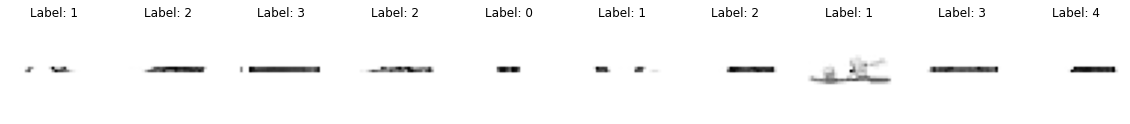

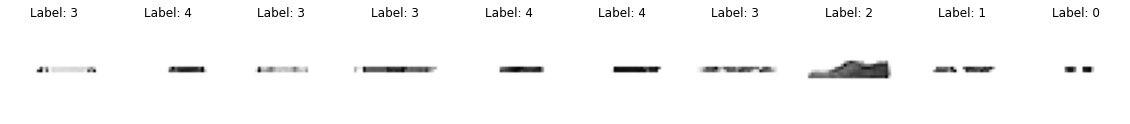

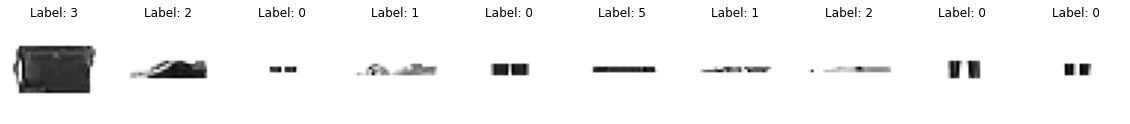

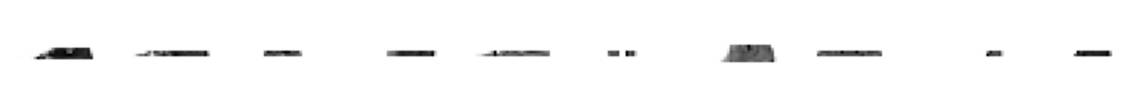

In [3]:
from torchvision.transforms.transforms import RandomRotation
# code for data augmentation pipeline 
print(f'unlabeled: {full_data["unlabeled_data"].shape}')
print(f'labeled data: {full_data["labeled_data"]["data"].shape}')
print(f'labeled labels: {full_data["labeled_data"]["labels"].shape}')

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils

# augmentations
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=(0,90)), 
        transforms.ColorJitter(),
        
])

# augmentations = []

batch_size = 10

class UnlabeledDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.tensor(data)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx].numpy()).permute((1, 2, 0))
        return self.data[idx]


class LabeledDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.tensor(data['data'])
        self.labels = torch.tensor(data['labels'])
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx].numpy()).permute((1, 2, 0)), self.labels[idx]
        return self.data[idx], self.labels[idx]


def show_images(x, y=None, ncols=batch_size):
    """ plots first ncols images in a batch """
    x = x.view(ncols, 32, 32)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys")
        ax[idx].axis('off')
        if y is not None:
            ax[idx].set_title(f'Label: {torch.nonzero(y[idx]).item()}')
    plt.show()

labeled_ds = LabeledDataset(full_data['labeled_data'], transform=transform)
repr_ds1 = LabeledDataset(full_data['representative_set_1'], transform=transform)
repr_ds2 = LabeledDataset(full_data['representative_set_2'], transform=transform)
unlabeled_ds = UnlabeledDataset(full_data['unlabeled_data'], transform=transform)

print('examples from labeled, repr1, repr2, unlabeled')
for dl in [DataLoader(ds, batch_size=batch_size, shuffle=True)
           for ds in [labeled_ds, repr_ds1, repr_ds2]]:
    for (x, y) in dl:
        # TODO: figure out why are the images flipped???
        show_images(x, y)
        break
for (x) in DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True):
    show_images(x)
    break

# Model definitions

In [4]:
# code for model definitions goes here
# model goals:
# 1. detect out of distribution data
# 2. give low (10) dimensional description of dataset in terms of the 5 modes
# 3. classify remaining data points into the 5 classes

# TODO ideas:
# generative model (task 1),
# embedding (task 2)
# self-supervised learning (task 3),

# similar to VAE practical 5.2
# e.g. train classifier on the vae's latent space by adding cross-entropy loss to the training
# (and thus third model encoder, decoder, classifier)

import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.fc_input = nn.Linear(input_dim, hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear (hidden_dim, latent_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_input(x))
        h = torch.relu(self.fc_hidden(h))
        mu = self.fc_mu(h)
        log_sigma = self.fc_sigma(h)
        z = self.reparameterization(mu, log_sigma)

        return z, mu, log_sigma
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.rand_like(sigma)
        z = mu + sigma * epsilon
        
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_hidden1(x))
        h = torch.relu(self.fc_hidden2(h))
        x_reconstr = torch.sigmoid(self.fc_output(h))
        return x_reconstr


class Classifier(nn.Module):
    def __init__(self, latent_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Sequential(nn.Linear(hidden_dim, n_classes),nn.Softmax(dim=1))
        
    def forward(self, x):
        h = torch.relu(self.fc_hidden1(x))
        h = torch.relu(self.fc_hidden2(h))
        out = self.fc_output(h)
        return out


class VAE(nn.Module):
    def __init__(self, encoder, decoder, classifier):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
            
    def forward(self, x):
        x = x.view(batch_size, encoder.input_dim)
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        y = self.classifier(z)
        # From mu and log_sigma, find if it's out of bounds, and the index of it.
        
        # Overwrite y

        return x_reconstr, mu, log_sigma, y

In [236]:
torch.save(encoder, "encoder.model")
torch.save(decoder, "decoder.model")
torch.save(classifier, "classifier.model")
torch.save(vae, "vae.model")

# Training and validation loop

In [194]:
# write your training and validation loop here

input_dim = 32*32
hidden_dim = 50
latent_dim = 10
n_classes = 5

encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=input_dim)
classifier = Classifier(latent_dim=latent_dim, hidden_dim=hidden_dim, n_classes=n_classes)

vae = VAE(encoder=encoder, decoder=decoder, classifier=classifier)

In [195]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Encoder Model has {count_parameters(encoder)} parameters')
print(f'Decoder Model has {count_parameters(decoder)} parameters')
print(f'Classifier Model has {count_parameters(classifier)} parameters')
print(f'VAE Model has {count_parameters(vae)} parameters')

Encoder Model has 54820 parameters
Decoder Model has 55324 parameters
Classifier Model has 3355 parameters
VAE Model has 113499 parameters


In [196]:
# Then, train on the labeled data
# perform training

# train on the labeled data
epochs = 10

import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn

lr = 1e-4

def loss_function(x, x_reconstr, mu, log_sigma, y=None, y_pred=None):
    classify_loss = 0
    reconstr_loss = nn.functional.mse_loss(x_reconstr.reshape(-1,1,32,32), x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)

    if y is not None and y_pred is not None:
        # TODO: add classification loss here (cross entropy)
        # TODO: should this also add some kind of divergence to push different classes away?????
        # criterion = nn.functional.cross_entropy()
        classify_loss = nn.functional.cross_entropy(y_pred,y).item()

    total_loss = reconstr_loss + kl_loss + classify_loss

    return total_loss, reconstr_loss, kl_loss, classify_loss
# def loss_function(x, x_reconstr, mu, log_sigma, y=None, y_pred=None):
#     reconstr_loss = nn.functional.mse_loss(x_reconstr.reshape(-1,1,32,32), x, reduction='sum')
#     kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
#     total_loss = reconstr_loss + kl_loss
#     if y is not None and y_pred is not None:
#         # TODO: add classification loss here (cross entropy)
#         # TODO: should this also add some kind of divergence to push different classes away?????
#         pass
#     return total_loss, reconstr_loss, kl_loss

def fit_unlabeled(model, dl):
    print("Start training VAE...")
    loss_graph = {'overall': [], 'reconstr': [], 'kl': []}
    

    for epoch in tqdm(range(epochs)):
        model.train()
        # optimizer = optim.Adam(model.parameters(), lr=lr)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        overall_loss = 0
        overall_reconstr_loss = 0
        overall_kl_loss = 0
        n_datapoints = 0
        for x in dl:
            optimizer.zero_grad()

            # y is unused for unlabeled data
            x_reconstr, mu, log_sigma, _ = model(x)
            loss, reconstr_loss, kl_loss, _ = loss_function(x, x_reconstr, mu, log_sigma)
 
            overall_loss += loss.item()
            overall_reconstr_loss += reconstr_loss.item()
            overall_kl_loss += kl_loss.item()
            
            loss.backward()
            optimizer.step()
            
            n_datapoints += batch_size
        loss_graph['overall'].append(overall_loss / n_datapoints)
        loss_graph['reconstr'].append(overall_reconstr_loss / n_datapoints)
        loss_graph['kl'].append(overall_kl_loss / n_datapoints)

    print("Training complete!")
    return loss_graph

dl_dl = DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True)
graph = fit_unlabeled(vae, dl_dl)

Start training VAE...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.31s/it]

Training complete!


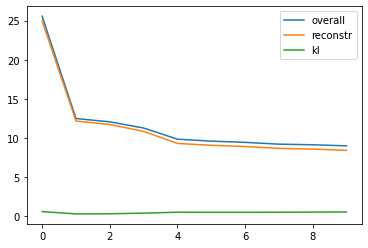

In [197]:
for label in ['overall', 'reconstr', 'kl']:
    plt.plot(np.arange(0, epochs), graph[label], label=label)
plt.legend()
plt.show()


torch.Size([10, 1, 32, 32])
torch.Size([10, 1024])


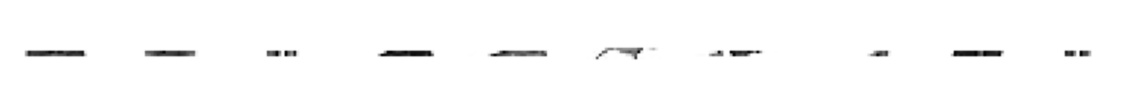

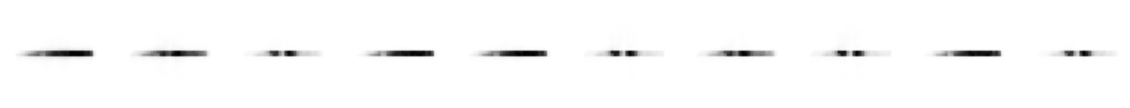

In [198]:
# Show some examples of vae-encoded images
for x in DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True):
    with torch.no_grad():
        x_reconstr, _, _, _ = vae(x)
        print(x.shape)
        print(x_reconstr.shape)
        show_images(x)
        show_images(x_reconstr)
        break

In [199]:
# perform training

# First, train on the unlabeled data
epochs = 50

import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional

lr = 5e-3

def loss_function(x, x_reconstr, mu, log_sigma, y=None, y_pred=None):
    classify_loss = 0
    reconstr_loss = nn.functional.mse_loss(x_reconstr.reshape(-1,1,32,32), x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)

    if y is not None and y_pred is not None:
        # TODO: should this also add some kind of divergence to push different classes away?????

        classify_loss = nn.functional.cross_entropy(y_pred,y)
        # classify_loss = torch.sum(-y * torch.log(y_pred) - (1 - y) * torch.log(1 - y_pred))

    total_loss = reconstr_loss + kl_loss + classify_loss
    
    return total_loss, reconstr_loss, kl_loss, classify_loss

def fit_labeled(model, dl):
    print("Start training VAE...")
    loss_graph = {'overall': [], 'reconstr': [], 'kl': [], 'classify': []}
    
    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.9)
        overall_loss = 0
        overall_reconstr_loss = 0
        overall_kl_loss = 0
        overall_classify_loss = 0
        n_datapoints = 0
        for (x,y) in dl:
            optimizer.zero_grad()

            x_reconstr, mu, log_sigma, y_pred = model(x)

            loss, reconstr_loss, kl_loss, classify_loss = loss_function(x, x_reconstr, mu, log_sigma, y, y_pred)
 
            overall_loss += loss.item()
            overall_reconstr_loss += reconstr_loss.item()
            overall_kl_loss += kl_loss.item()
            overall_classify_loss += classify_loss.item()
            
            loss.backward()
            optimizer.step()
            
            n_datapoints += batch_size
        loss_graph['overall'].append(overall_loss / n_datapoints)
        loss_graph['reconstr'].append(overall_reconstr_loss / n_datapoints)
        loss_graph['kl'].append(overall_kl_loss / n_datapoints)
        loss_graph['classify'].append(overall_classify_loss / n_datapoints)
        print(f"\n overall:{overall_loss / n_datapoints}\n reconstr:{overall_reconstr_loss / n_datapoints}\n kl:{overall_kl_loss / n_datapoints}\n classify:{overall_classify_loss / n_datapoints}")

    print("Training complete!")
    return loss_graph

graph = fit_labeled(vae, DataLoader(labeled_ds, batch_size=batch_size, shuffle=True))

Start training VAE...


  2%|█▋                                                                                 | 1/50 [00:02<01:38,  2.02s/it]


 overall:10.301745946884155
 reconstr:9.51658278656006
 kl:0.6358014801740647
 classify:0.14936164492368698


  4%|███▎                                                                               | 2/50 [00:03<01:35,  1.99s/it]


 overall:9.662496370315552
 reconstr:8.915756908416748
 kl:0.6007822932600975
 classify:0.14595717793703078


  6%|████▉                                                                              | 3/50 [00:05<01:33,  1.99s/it]


 overall:9.829443918228149
 reconstr:9.091776641845703
 kl:0.5909008923768997
 classify:0.14676634436845779


  8%|██████▋                                                                            | 4/50 [00:08<01:32,  2.01s/it]


 overall:9.522673913955689
 reconstr:8.82832378578186
 kl:0.5482333745956421
 classify:0.1461167704463005


 10%|████████▎                                                                          | 5/50 [00:10<01:31,  2.04s/it]


 overall:10.229894318580627
 reconstr:9.4824317445755
 kl:0.6003690705299377
 classify:0.14709351152181627


 12%|█████████▉                                                                         | 6/50 [00:12<01:28,  2.02s/it]


 overall:9.929413698196411
 reconstr:9.215623647689819
 kl:0.5682630262374878
 classify:0.14552701658010483


 14%|███████████▌                                                                       | 7/50 [00:14<01:28,  2.05s/it]


 overall:9.60122456741333
 reconstr:8.881448637008667
 kl:0.5750077580213546
 classify:0.14476816993951797


 16%|█████████████▎                                                                     | 8/50 [00:16<01:25,  2.03s/it]


 overall:9.67384527015686
 reconstr:8.89791864013672
 kl:0.6296620773673057
 classify:0.14626451855897904


 18%|██████████████▉                                                                    | 9/50 [00:18<01:23,  2.03s/it]


 overall:9.055804777145386
 reconstr:8.33870279121399
 kl:0.5716066489219666
 classify:0.14549533146619797


 20%|████████████████▍                                                                 | 10/50 [00:20<01:22,  2.06s/it]


 overall:9.399281673431396
 reconstr:8.66478754234314
 kl:0.589090984582901
 classify:0.14540315234661103


 22%|██████████████████                                                                | 11/50 [00:22<01:20,  2.05s/it]


 overall:9.776823734283447
 reconstr:9.024772583007813
 kl:0.6066389755606652
 classify:0.145412161052227


 24%|███████████████████▋                                                              | 12/50 [00:24<01:19,  2.09s/it]


 overall:9.343749130249023
 reconstr:8.600445459365845
 kl:0.5983421030044556
 classify:0.14496157199144363


 26%|█████████████████████▎                                                            | 13/50 [00:26<01:16,  2.07s/it]


 overall:8.851913331985473
 reconstr:8.14297069644928
 kl:0.5640730834007264
 classify:0.14486954057216644


 28%|██████████████████████▉                                                           | 14/50 [00:28<01:15,  2.08s/it]


 overall:9.109264841079712
 reconstr:8.327870811462402
 kl:0.6379782139062882
 classify:0.14341579180955888


 30%|████████████████████████▌                                                         | 15/50 [00:30<01:13,  2.10s/it]


 overall:9.400567014694214
 reconstr:8.613436983108521
 kl:0.6442532556056977
 classify:0.14287678855657576


 32%|██████████████████████████▏                                                       | 16/50 [00:32<01:10,  2.09s/it]


 overall:8.714100282669067
 reconstr:7.967137704849243
 kl:0.6048329362273216
 classify:0.14212965136766434


 34%|███████████████████████████▉                                                      | 17/50 [00:34<01:08,  2.07s/it]


 overall:9.95114439201355
 reconstr:9.14944861316681
 kl:0.6601185346841812
 classify:0.14157725983858108


 36%|█████████████████████████████▌                                                    | 18/50 [00:37<01:06,  2.08s/it]


 overall:9.20276472377777
 reconstr:8.427111558914184
 kl:0.6341606355905532
 classify:0.1414925491809845


 38%|███████████████████████████████▏                                                  | 19/50 [00:39<01:03,  2.06s/it]


 overall:9.332564952850342
 reconstr:8.49396250629425
 kl:0.6981622189283371
 classify:0.14044018405675887


 40%|████████████████████████████████▊                                                 | 20/50 [00:41<01:01,  2.06s/it]


 overall:9.136459749221801
 reconstr:8.361690898895263
 kl:0.6344471479654312
 classify:0.14032174509763717


 42%|██████████████████████████████████▍                                               | 21/50 [00:43<00:59,  2.04s/it]


 overall:9.063222000122071
 reconstr:8.300009922981262
 kl:0.6245455857515335
 classify:0.138666512966156


 44%|████████████████████████████████████                                              | 22/50 [00:45<00:57,  2.04s/it]


 overall:9.12420226097107
 reconstr:8.396354104042054
 kl:0.5872835675477982
 classify:0.1405645943880081


 46%|█████████████████████████████████████▋                                            | 23/50 [00:47<00:55,  2.05s/it]


 overall:9.252225786209106
 reconstr:8.475652510643005
 kl:0.6372729144692421
 classify:0.13930041831731796


 48%|███████████████████████████████████████▎                                          | 24/50 [00:49<00:53,  2.05s/it]


 overall:8.849831129074097
 reconstr:8.047391629219055
 kl:0.6630332866907119
 classify:0.1394062129855156


 50%|█████████████████████████████████████████                                         | 25/50 [00:51<00:50,  2.03s/it]


 overall:9.072875540733337
 reconstr:8.292020316123962
 kl:0.6416393051147461
 classify:0.1392158758044243


 52%|██████████████████████████████████████████▋                                       | 26/50 [00:53<00:48,  2.02s/it]


 overall:8.861094287872314
 reconstr:8.127528800010682
 kl:0.5943626535534858
 classify:0.1392028729915619


 54%|████████████████████████████████████████████▎                                     | 27/50 [00:55<00:46,  2.02s/it]


 overall:8.884292325973512
 reconstr:8.150755451202393
 kl:0.5929849092960358
 classify:0.1405519837141037


 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:57<00:44,  2.02s/it]


 overall:9.002499539375306
 reconstr:8.278843703269958
 kl:0.5834180421829224
 classify:0.14023777973651885


 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:59<00:42,  2.01s/it]


 overall:10.184725048065186
 reconstr:9.447049797058105
 kl:0.5943244367837905
 classify:0.14335085344314574


 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:01<00:39,  2.00s/it]


 overall:9.350468946456909
 reconstr:8.590420082092285
 kl:0.6181414433717728
 classify:0.14190745562314988


 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:03<00:37,  1.99s/it]


 overall:9.239241926193237
 reconstr:8.504868985176087
 kl:0.5912620412111282
 classify:0.1431108636856079


 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:05<00:35,  1.98s/it]


 overall:9.037490703582764
 reconstr:8.337850768089295
 kl:0.558054888010025
 classify:0.14158508932590486


 66%|██████████████████████████████████████████████████████                            | 33/50 [01:07<00:33,  1.98s/it]


 overall:8.718166807174683
 reconstr:8.0209140625
 kl:0.5554468392133712
 classify:0.14180586683750152


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:09<00:31,  1.98s/it]


 overall:8.985533601760864
 reconstr:8.214930466651916
 kl:0.6311363967657089
 classify:0.13946673864126205


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:11<00:29,  1.98s/it]


 overall:9.143267693519592
 reconstr:8.419844287872314
 kl:0.5820980031490326
 classify:0.1413254747390747


 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:13<00:27,  1.98s/it]


 overall:8.854662817001342
 reconstr:8.120678490638733
 kl:0.591451824605465
 classify:0.14253249210119248


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:15<00:25,  1.98s/it]


 overall:8.8344717502594
 reconstr:8.105298748016358
 kl:0.5870008316636085
 classify:0.1421721447110176


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:17<00:23,  1.98s/it]


 overall:9.46370112323761
 reconstr:8.684586191177369
 kl:0.637162558555603
 classify:0.1419523513317108


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:19<00:21,  1.98s/it]


 overall:9.393584102630616
 reconstr:8.631395318031311
 kl:0.6198747420310974
 classify:0.14231407141685487


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:21<00:20,  2.01s/it]


 overall:8.877132844924926
 reconstr:8.13219696521759
 kl:0.6034227894544602
 classify:0.14151311337947844


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:23<00:18,  2.06s/it]


 overall:9.081333410263062
 reconstr:8.295054167747498
 kl:0.6448674842119216
 classify:0.1414117651581764


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:25<00:16,  2.07s/it]


 overall:8.46630137348175
 reconstr:7.7241571378707885
 kl:0.6004342923164367
 classify:0.1417099660038948


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:27<00:14,  2.08s/it]


 overall:9.75040722465515
 reconstr:9.029693306922912
 kl:0.5772356687188148
 classify:0.14347827941179275


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:29<00:12,  2.05s/it]


 overall:8.847211891174316
 reconstr:8.121754929542542
 kl:0.5847517348527909
 classify:0.14070524311065674


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:31<00:10,  2.03s/it]


 overall:9.998763881683349
 reconstr:9.257867144584656
 kl:0.5985656646490097
 classify:0.14233104246854783


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:33<00:08,  2.03s/it]


 overall:9.378886541366578
 reconstr:8.645953659057618
 kl:0.5916239357590676
 classify:0.1413089656829834


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:35<00:06,  2.01s/it]


 overall:9.39238073348999
 reconstr:8.675980224609376
 kl:0.5753577855229378
 classify:0.1410427087545395


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:37<00:04,  2.00s/it]


 overall:9.425900873184204
 reconstr:8.739083841323852
 kl:0.5460194286108017
 classify:0.14079758137464524


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:39<00:01,  2.00s/it]


 overall:9.452835035324096
 reconstr:8.784132422447204
 kl:0.5281594060659408
 classify:0.1405431794524193


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:41<00:00,  2.03s/it]


 overall:9.640930150985717
 reconstr:8.911917590141297
 kl:0.5884759760499001
 classify:0.1405365628004074
Training complete!


In [200]:
graph

{'overall': [10.301745946884155,
  9.662496370315552,
  9.829443918228149,
  9.522673913955689,
  10.229894318580627,
  9.929413698196411,
  9.60122456741333,
  9.67384527015686,
  9.055804777145386,
  9.399281673431396,
  9.776823734283447,
  9.343749130249023,
  8.851913331985473,
  9.109264841079712,
  9.400567014694214,
  8.714100282669067,
  9.95114439201355,
  9.20276472377777,
  9.332564952850342,
  9.136459749221801,
  9.063222000122071,
  9.12420226097107,
  9.252225786209106,
  8.849831129074097,
  9.072875540733337,
  8.861094287872314,
  8.884292325973512,
  9.002499539375306,
  10.184725048065186,
  9.350468946456909,
  9.239241926193237,
  9.037490703582764,
  8.718166807174683,
  8.985533601760864,
  9.143267693519592,
  8.854662817001342,
  8.8344717502594,
  9.46370112323761,
  9.393584102630616,
  8.877132844924926,
  9.081333410263062,
  8.46630137348175,
  9.75040722465515,
  8.847211891174316,
  9.998763881683349,
  9.378886541366578,
  9.39238073348999,
  9.425900

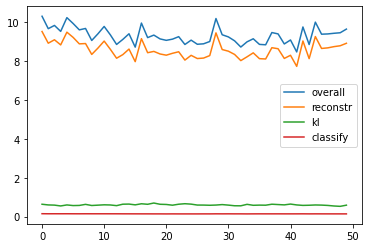

In [201]:
for label in ['overall', 'reconstr', 'kl', 'classify']:
    plt.plot(np.arange(0, epochs), graph[label], label=label)
plt.legend()
plt.show()

# Inspection, Validation, and Analysis

In [ ]:
# Inspect, validate, and analyse your trained model

In [216]:
# perform testing
mu1, mu2, mu3, mu4, mu5, mu_out = list(), list(), list(), list(), list(), list()
s1, s2, s3, s4, s5, s_out = list(), list(), list(), list(), list(), list()

def test_loss_function(x, x_reconstr, mu, log_sigma, y=None, y_pred=None):
    classify_loss = 0
    reconstr_loss = nn.functional.mse_loss(x_reconstr.reshape(-1,1,32,32), x, reduction='sum')

    kl_loss = torch.zeros((10, 1))
    for inx, _ in enumerate(kl_loss):
        kl_loss[inx] = 0.5 * torch.sum(mu[inx].pow(2) + (2*log_sigma[inx]).exp() - 2*log_sigma[inx] - 1)
        
    pad_zero = torch.zeros((10, 1))
    y_pred = torch.hstack((y_pred, pad_zero))
    
    for inx, kl_row in enumerate(kl_loss):
        if kl_row < 1*0.1 or kl_row > 1*1.9:
            y_pred[inx] = torch.Tensor([0, 0, 0, 0, 0, 1])
            
    if y is not None and y_pred is not None:
        # TODO: should this also add some kind of divergence to push different classes away?????

        classify_loss = nn.functional.cross_entropy(y_pred,y)
        # classify_loss = torch.sum(-y * torch.log(y_pred) - (1 - y) * torch.log(1 - y_pred))
    
    total_loss = reconstr_loss + sum(kl_loss)[0] + classify_loss
    
    return total_loss, reconstr_loss, sum(kl_loss)[0], classify_loss

def test_labeled(model, dl):
    print("Start testing VAE...")
    loss_graph = {'overall': [], 'reconstr': [], 'kl': [], 'classify': []}
    
    model.eval()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    overall_classify_loss = 0
    n_datapoints = 0
    with torch.no_grad():
        for (x,y) in dl:
            if x.shape[0] != 10:
                continue
            x_reconstr, mu, log_sigma, y_pred = model(x)
            
            for i in range(batch_size):
                if y[i][0] == 1:
                    mu1.append(mu[i][0])
                    s1.append(log_sigma[i][0])
                elif y[i][1] == 1:
                    mu2.append(mu[i][0])
                    s2.append(log_sigma[i][0])
                elif y[i][2] == 1:
                    mu3.append(mu[i][0])
                    s3.append(log_sigma[i][0])
                elif y[i][3] == 1:
                    mu4.append(mu[i][0])
                    s4.append(log_sigma[i][0])
                elif y[i][4] == 1:
                    mu5.append(mu[i][0])
                    s5.append(log_sigma[i][0])
                elif y[i][5] == 1:
                    mu_out.append(mu[i][0])
                    s_out.append(log_sigma[i][0])

            loss, reconstr_loss, kl_loss, classify_loss = test_loss_function(x, x_reconstr, mu, log_sigma, y, y_pred)

            overall_loss += loss.item()
            overall_reconstr_loss += reconstr_loss.item()
            overall_kl_loss += kl_loss.item()
            overall_classify_loss += classify_loss.item()

            n_datapoints += batch_size
    
    loss_graph['overall'].append(overall_loss / n_datapoints)
    loss_graph['reconstr'].append(overall_reconstr_loss / n_datapoints)
    loss_graph['kl'].append(overall_kl_loss / n_datapoints)
    loss_graph['classify'].append(overall_classify_loss / n_datapoints)
    print(f"\n overall:{overall_loss / n_datapoints}\n reconstr:{overall_reconstr_loss / n_datapoints}\n kl:{overall_kl_loss / n_datapoints}\n classify:{overall_classify_loss / n_datapoints}")

    return loss_graph

graph = test_labeled(vae, DataLoader(repr_ds1, batch_size=batch_size, shuffle=True))

Start testing VAE...

 overall:8.69074814206078
 reconstr:8.016953491937546
 kl:0.5108774901571728
 classify:0.16291716711861748


In [219]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu_mu1 = np.mean(mu1)
mu_mu2 = np.mean(mu2)
mu_mu3 = np.mean(mu3)
mu_mu4 = np.mean(mu4)
mu_mu5 = np.mean(mu5)
mu_mu_out = np.mean(mu_out)

s_s1 = np.sqrt(sum([x**2 for x in s1])/len(s1))
s_s2 = np.sqrt(sum([x**2 for x in s2])/len(s2))
s_s3 = np.sqrt(sum([x**2 for x in s3])/len(s3))
s_s4 = np.sqrt(sum([x**2 for x in s4])/len(s4))
s_s5 = np.sqrt(sum([x**2 for x in s5])/len(s5))
s_s_out = np.sqrt(sum([x**2 for x in s_out])/len(s_out))

mu = np.mean([mu_mu1, mu_mu2, mu_mu3, mu_mu4, mu_mu5, mu_mu_out])
sigma = np.sqrt(sum([s_s1**2, s_s2**2, s_s3**2, s_s4**2, s_s5**2, s_s_out**2]))

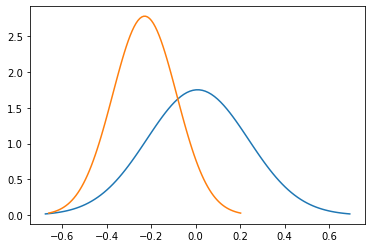

In [239]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_1 = np.linspace(mu_mu1 - 3*s_s1, mu_mu1 + 3*s_s1, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_1, stats.norm.pdf(x_1, mu_mu1, s_s1))
plt.show()

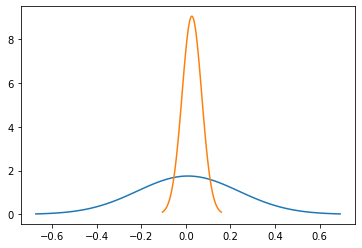

In [231]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_2 = np.linspace(mu_mu2 - 3*s_s2, mu_mu2 + 3*s_s2, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_2, stats.norm.pdf(x_2, mu_mu2, s_s2))
plt.show()

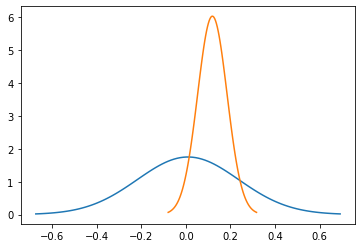

In [232]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_3 = np.linspace(mu_mu3 - 3*s_s3, mu_mu3 + 3*s_s3, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_3, stats.norm.pdf(x_3, mu_mu3, s_s3))
plt.show()

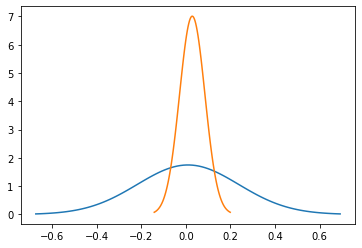

In [233]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_4 = np.linspace(mu_mu4 - 3*s_s4, mu_mu4 + 3*s_s4, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_4, stats.norm.pdf(x_4, mu_mu4, s_s4))
plt.show()

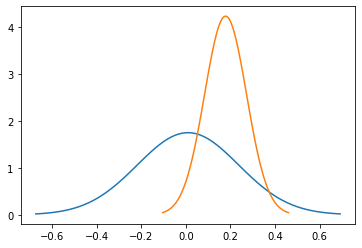

In [234]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_5 = np.linspace(mu_mu5 - 3*s_s5, mu_mu5 + 3*s_s5, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_5, stats.norm.pdf(x_5, mu_mu5, s_s5))
plt.show()

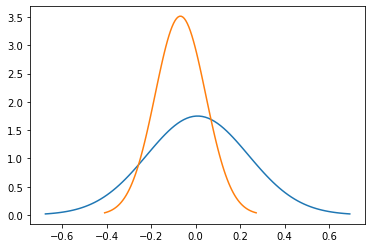

In [235]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_out = np.linspace(mu_mu_out - 3*s_s_out, mu_mu_out + 3*s_s_out, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_out, stats.norm.pdf(x_out, mu_mu_out, s_s_out))
plt.show()

In [206]:
## TODO: ROC haven't finished

def test(model, dl):
    '''
    Calculate FP, TP -> ROC.
    Return scores: (FP, TP, accuracy)
    '''
    model = model.eval()
    running_tp = 0.0
    running_fp = 0.0
    running_tn = 0.0
    running_fn = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for (x, y) in dl:
            if x.shape[0] != 10:
                continue
            x_reconstr, mu, log_sigma, y_pred = model(x)
            
            y_pred_interpreted = torch.zeros(batch_size, 5)
            
            for inx, row in enumerate(y_pred):
                y_pred_interpreted[inx][torch.argmax(row)] = 1
            
            for r_y, r_pred in zip(y, y_pred_interpreted):
                for i_r_y, i_r_pred in zip(r_y, r_pred):
                    if i_r_pred == 1 and i_r_y == 1:
                        running_tp += 1
                    elif i_r_pred == 1 and i_r_y == 0:
                        running_fp += 1
                    elif i_r_pred == 0 and i_r_y == 0:
                        running_tn += 0
                    elif i_r_pred == 0 and i_r_y == 1:
                        running_fn += 0
            
        running_acc = (running_tp + running_tn) / (running_tn + running_fn + running_fp + running_tn)
        
        n = len(dl)
        return (running_fp / n, running_tp / n, running_acc)

def plot_roc(model, loader, thresholds, desc="Validation"):
    rocs = [test(model, loader, t) for t in thresholds]
    # Split tuples into x and y, x = FP and y = TP
    x = [roc[0] for roc in rocs]
    y = [roc[1] for roc in rocs]
    # z = accuracy, is not plotted
    z = [roc[2] for roc in rocs]
    plt.plot(x, y)
    plt.title(f"{desc} ROC")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    return x, y, z


In [207]:
test(vae,DataLoader(repr_ds1, batch_size=batch_size, shuffle=True))

(5.481132075471698, 4.4245283018867925, 0.8072289156626506)